<a href="https://colab.research.google.com/github/Tongxi-Hu/deep-learning/blob/main/nyu/3_sequence_model_with_rnn_and_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 sequence classification using rnn vs lstm

In [1]:
import numpy as np
import six

def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` for variable length strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

class EchoData():

    def __init__(self, series_length=40000, batch_size=32,
                 echo_step=3, truncated_length=10, seed=None):

        self.series_length = series_length
        self.truncated_length = truncated_length
        self.n_batches = series_length//truncated_length

        self.echo_step = echo_step
        self.batch_size = batch_size
        if seed is not None:
            np.random.seed(seed)
        self.x_batch = None
        self.y_batch = None
        self.x_chunks = []
        self.y_chunks = []
        self.generate_new_series()
        self.prepare_batches()

    def __getitem__(self, index):
        if index == 0:
            self.generate_new_series()
            self.prepare_batches()
        return self.x_chunks[index], self.y_chunks[index]

    def __len__(self):
        return self.n_batches

    def generate_new_series(self):
        x = np.random.choice(
            2,
            size=(self.batch_size, self.series_length),
            p=[0.5, 0.5])
        y = np.roll(x, self.echo_step, axis=1)
        y[:, 0:self.echo_step] = 0
        self.x_batch = x
        self.y_batch = y

    def prepare_batches(self):
        x = np.expand_dims(self.x_batch, axis=-1)
        y = np.expand_dims(self.y_batch, axis=-1)
        self.x_chunks = np.split(x, self.n_batches, axis=1)
        self.y_chunks = np.split(y, self.n_batches, axis=1)

class TemporalOrderExp6aSequence():
    """
    From Hochreiter&Schmidhuber(1997):

        The goal is to classify sequences. Elements and targets are represented locally
        (input vectors with only one non-zero bit). The sequence starts with an B, ends
        with a E (the "trigger symbol") and otherwise consists of randomly chosen symbols
        from the set {a, b, c, d} except for two elements at positions t1 and t2 that are
        either X or Y . The sequence length is randomly chosen between 100 and 110, t1 is
        randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60.
        There are 4 sequence classes Q, R, S, U which depend on the temporal order of X and Y.
        The rules are:
            X, X -> Q,
            X, Y -> R,
            Y , X -> S,
            Y , Y -> U.

    """

    def __init__(self, length_range=(100, 111), t1_range=(10, 21), t2_range=(50, 61),
                 batch_size=32, seed=None):

        self.classes = ['Q', 'R', 'S', 'U']
        self.n_classes = len(self.classes)

        self.relevant_symbols = ['X', 'Y']
        self.distraction_symbols = ['a', 'b', 'c', 'd']
        self.start_symbol = 'B'
        self.end_symbol = 'E'

        self.length_range = length_range
        self.t1_range = t1_range
        self.t2_range = t2_range
        self.batch_size = batch_size

        if seed is not None:
            np.random.seed(seed)

        all_symbols = self.relevant_symbols + self.distraction_symbols + \
                      [self.start_symbol] + [self.end_symbol]
        self.n_symbols = len(all_symbols)
        self.s_to_idx = {s: n for n, s in enumerate(all_symbols)}
        self.idx_to_s = {n: s for n, s in enumerate(all_symbols)}

        self.c_to_idx = {c: n for n, c in enumerate(self.classes)}
        self.idx_to_c = {n: c for n, c in enumerate(self.classes)}

    def generate_pair(self):
        length = np.random.randint(self.length_range[0], self.length_range[1])
        t1 = np.random.randint(self.t1_range[0], self.t1_range[1])
        t2 = np.random.randint(self.t2_range[0], self.t2_range[1])

        x = np.random.choice(self.distraction_symbols, length)
        x[0] = self.start_symbol
        x[-1] = self.end_symbol

        y = np.random.choice(self.classes)
        if y == 'Q':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[0]
        elif y == 'R':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[1]
        elif y == 'S':
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[0]
        else:
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[1]

        return ''.join(x), y

    # encoding/decoding single instance version

    def encode_x(self, x):
        idx_x = [self.s_to_idx[s] for s in x]
        return to_categorical(idx_x, num_classes=self.n_symbols)

    def encode_y(self, y):
        idx_y = self.c_to_idx[y]
        return to_categorical(idx_y, num_classes=self.n_classes)

    def decode_x(self, x):
        x = x[np.sum(x, axis=1) > 0]    # remove padding
        return ''.join([self.idx_to_s[pos] for pos in np.argmax(x, axis=1)])

    def decode_y(self, y):
        return self.idx_to_c[np.argmax(y)]

    # encoding/decoding batch versions

    def encode_x_batch(self, x_batch):
        return pad_sequences([self.encode_x(x) for x in x_batch],
                             maxlen=self.length_range[1])

    def encode_y_batch(self, y_batch):
        return np.array([self.encode_y(y) for y in y_batch])

    def decode_x_batch(self, x_batch):
        return [self.decode_x(x) for x in x_batch]

    def decode_y_batch(self, y_batch):
        return [self.idx_to_c[pos] for pos in np.argmax(y_batch, axis=1)]

    def __len__(self):
        """ Let's assume 1000 sequences as the size of data. """
        return int(1000. / self.batch_size)

    def __getitem__(self, index):
        batch_x, batch_y = [], []
        for _ in range(self.batch_size):
            x, y = self.generate_pair()
            batch_x.append(x)
            batch_y.append(y)
        return self.encode_x_batch(batch_x), self.encode_y_batch(batch_y)

    class DifficultyLevel:
        """ On HARD, settings are identical to the original settings from the '97 paper."""
        EASY, NORMAL, MODERATE, HARD, NIGHTMARE = range(5)

    @staticmethod
    def get_predefined_generator(difficulty_level, batch_size=32, seed=8382):
        EASY = TemporalOrderExp6aSequence.DifficultyLevel.EASY
        NORMAL = TemporalOrderExp6aSequence.DifficultyLevel.NORMAL
        MODERATE = TemporalOrderExp6aSequence.DifficultyLevel.MODERATE
        HARD = TemporalOrderExp6aSequence.DifficultyLevel.HARD

        if difficulty_level == EASY:
            length_range = (7, 9)
            t1_range = (1, 3)
            t2_range = (4, 6)
        elif difficulty_level == NORMAL:
            length_range = (30, 41)
            t1_range = (2, 6)
            t2_range = (20, 28)
        elif difficulty_level == MODERATE:
            length_range = (60, 81)
            t1_range = (10, 21)
            t2_range = (45, 55)
        elif difficulty_level == HARD:
            length_range = (100, 111)
            t1_range = (10, 21)
            t2_range = (50, 61)
        else:
            length_range = (300, 501)
            t1_range = (10, 81)
            t2_range = (250, 291)
        return TemporalOrderExp6aSequence(length_range, t1_range, t2_range,
                                          batch_size, seed)
    

### 1. Dataset Exploration

In [6]:
example_generator=TemporalOrderExp6aSequence.get_predefined_generator(
    difficulty_level=TemporalOrderExp6aSequence.DifficultyLevel.EASY,
    batch_size=32
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [7]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


### 2. Defining the Model

In [8]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size) -> None:
        super().__init__()
        self.rnn=torch.nn.RNN(input_size,hidden_size,nonlinearity="relu",batch_first=True)
        self.linear=torch.nn.Linear(hidden_size,output_size)
    def forward(self,x):
        h=self.rnn(x)[0]
        x=self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size) -> None:
        super().__init__()
        self.lstm=torch.nn.LSTM(input_size,hidden_size,batch_first=False)
        self.linear=torch.nn.Linear(hidden_size,output_size)
    def forward(self,x):
        h=self.lstm(x)[0]
        x=self.linear(h)
        return x
    def get_states_across_time(self,x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

### 3. Defining the Training Loop

In [9]:
def train(model,train_data_gen,criterion,optimizer,device):
    model.train()
    num_correct=0

    for batch_idx in range(len(train_data_gen)):
        data,target=train_data_gen[batch_idx]
        data,target=torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
        output=model(data)
        output=output[:,-1,:]
        target = target.argmax(dim=1)
        loss = criterion(output, target) 
        optimizer.zero_grad()  
        loss.backward() 
        optimizer.step() 
        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()


### 4. Defining the Testing Loop

In [10]:
def test(model, test_data_gen, criterion, device):
    model.eval()
    num_correct = 0
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)
            output = model(data)
            output = output[:, -1, :]
            target = target.argmax(dim=1)
            loss = criterion(output, target)
            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

### 5. Putting it All Together


In [11]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Remove xticks for vectors
    ax2.set_xticks(tuple())
    ax3.set_xticks(tuple())
    
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)


colors = dict(
    aqua='#8dd3c7',
    yellow='#ffffb3',
    lavender='#bebada',
    red='#fb8072',
    blue='#80b1d3',
    orange='#fdb462',
    green='#b3de69',
    pink='#fccde5',
    grey='#d9d9d9',
    violet='#bc80bd',
    unk1='#ccebc5',
    unk2='#ffed6f',
)


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

# print html
def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

# get appropriate color for value
def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]

def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)

def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)


# Let's only focus on the last time step for now
# First, the cell state (Long term memory)
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))

In [12]:
set_default()

In [13]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

### 6 Simple RNN: 10 Epochs

[Epoch 1/10] loss: 1.4213, acc: 24.29% - test_loss: 1.3710, test_acc: 31.35%
[Epoch 2/10] loss: 1.3603, acc: 30.75% - test_loss: 1.3846, test_acc: 37.50%
[Epoch 3/10] loss: 1.3673, acc: 40.22% - test_loss: 1.3910, test_acc: 40.12%
[Epoch 4/10] loss: 1.3636, acc: 39.82% - test_loss: 1.3435, test_acc: 43.85%
[Epoch 5/10] loss: 1.2752, acc: 44.35% - test_loss: 1.3282, test_acc: 36.59%
[Epoch 6/10] loss: 1.2631, acc: 40.22% - test_loss: 1.2412, test_acc: 41.03%
[Epoch 7/10] loss: 1.2340, acc: 44.35% - test_loss: 1.2670, test_acc: 47.58%
[Epoch 8/10] loss: 1.1193, acc: 50.40% - test_loss: 1.2446, test_acc: 48.69%
[Epoch 9/10] loss: 1.2194, acc: 48.89% - test_loss: 1.1098, test_acc: 50.81%
[Epoch 10/10] loss: 1.0805, acc: 48.69% - test_loss: 1.0649, test_acc: 52.72%


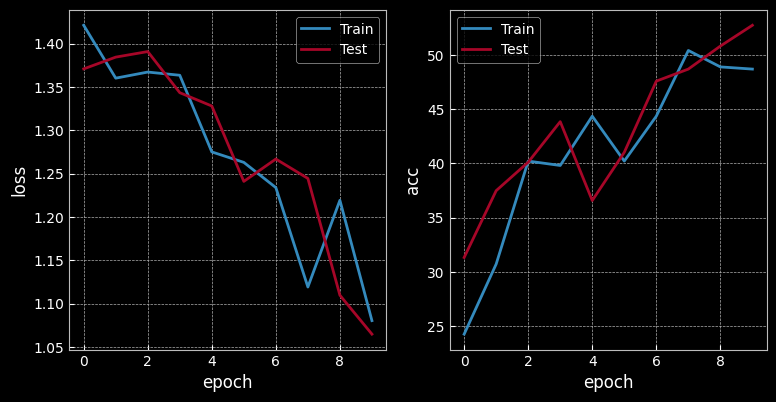

In [15]:
# Setup the training and test data generators
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)


In [16]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([4, 8])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])
torch.Size([4, 4])
torch.Size([4])


### 7 Simple LSTM: 10 Epochs

[Epoch 1/10] loss: 1.3327, acc: 25.40% - test_loss: 1.4529, test_acc: 23.19%
[Epoch 2/10] loss: 1.4128, acc: 24.29% - test_loss: 1.4149, test_acc: 23.69%
[Epoch 3/10] loss: 1.3908, acc: 25.00% - test_loss: 1.4066, test_acc: 26.61%
[Epoch 4/10] loss: 1.3722, acc: 22.88% - test_loss: 1.3817, test_acc: 24.90%
[Epoch 5/10] loss: 1.4206, acc: 25.81% - test_loss: 1.3846, test_acc: 24.09%
[Epoch 6/10] loss: 1.3849, acc: 23.79% - test_loss: 1.3990, test_acc: 28.02%
[Epoch 7/10] loss: 1.3889, acc: 21.77% - test_loss: 1.3774, test_acc: 25.40%
[Epoch 8/10] loss: 1.3884, acc: 20.97% - test_loss: 1.3830, test_acc: 24.40%
[Epoch 9/10] loss: 1.3871, acc: 25.20% - test_loss: 1.3905, test_acc: 23.79%
[Epoch 10/10] loss: 1.3872, acc: 25.20% - test_loss: 1.3876, test_acc: 26.11%


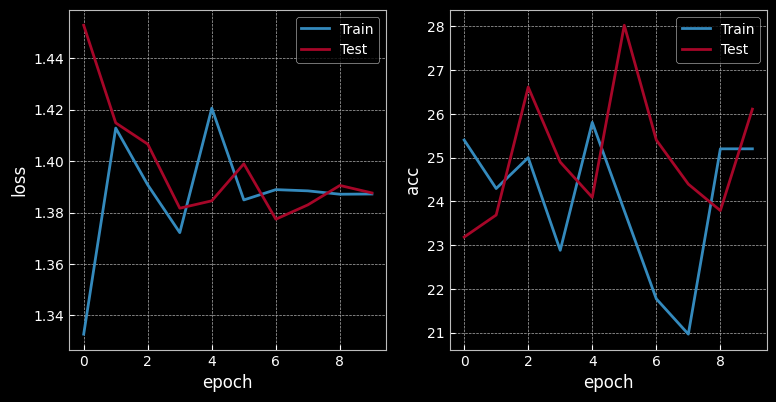

torch.Size([16, 8])
torch.Size([16, 4])
torch.Size([16])
torch.Size([16])
torch.Size([4, 4])
torch.Size([4])


In [17]:
# Setup the training and test data generators
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

for parameter_group in list(model.parameters()):
    print(parameter_group.size())


### 8 visualize lstm

[Epoch 100/100] loss: 1.3854, acc: 23.39% - test_loss: 1.3905, test_acc: 25.00%


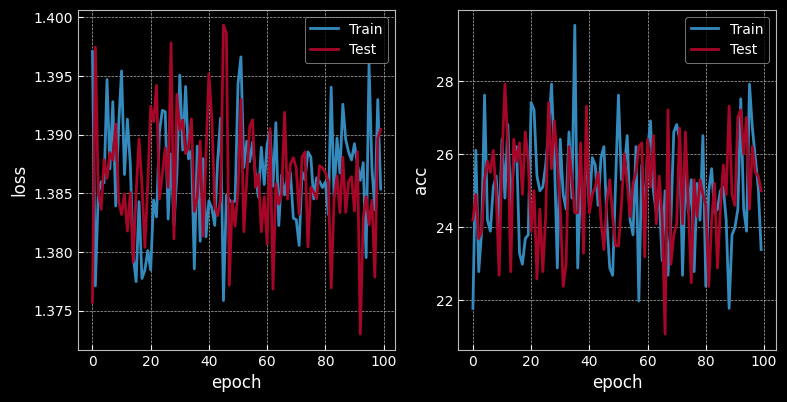

In [22]:
# For reproducibility
torch.manual_seed(1)

# Setup the training and test data generators
difficulty     = TemporalOrderExp6aSequence.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)
test_data_gen  = TemporalOrderExp6aSequence.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 12
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 100

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False)

In [23]:
# Get hidden (H) and cell (C) batch state given a batch input (X)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    data = test_data_gen[0][0]
    X = torch.from_numpy(data).float().to(device)
    H_t, C_t = model.get_states_across_time(X)

In [24]:
print("Color range is as follows:")
print_colourbar()

Color range is as follows:


In [ ]:
plot_state(X.cpu(), C_t, b=0, decoder=test_data_gen.decode_x)  # 3, 6, 9


In [ ]:
plot_state(X.cpu(), H_t, b=0, decoder=test_data_gen.decode_x)